In [1]:
#add spex templates to selection function
#select the highest SNR spectra of each spectral type i.e 

In [2]:
import splat
import wisps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import numba
%matplotlib inline

In [3]:
splat.initializeStandards()

In [4]:
spts=np.array([splat.typeToNum(x) for x in np.arange(17, 42)])

In [5]:
spts

array(['M7.0', 'M8.0', 'M9.0', 'L0.0', 'L1.0', 'L2.0', 'L3.0', 'L4.0',
       'L5.0', 'L6.0', 'L7.0', 'L8.0', 'L9.0', 'T0.0', 'T1.0', 'T2.0',
       'T3.0', 'T4.0', 'T5.0', 'T6.0', 'T7.0', 'T8.0', 'T9.0', 'Y0.0',
       'Y1.0'], dtype='<U4')

In [6]:
splat_db=splat.searchLibrary(vlm=True, giant=False, young=False)

In [7]:
df=splat_db[splat_db.SPEX_TYPE.isin(spts)]

In [8]:
splat_within_snr=df[df.MEDIAN_SNR.between(50, 200)]

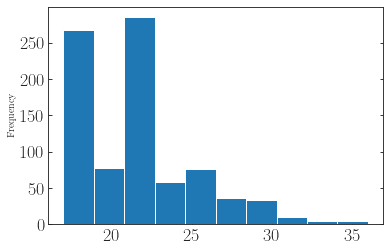

In [9]:
splat_within_snr.SPEX_TYPE.apply(splat.typeToNum).plot(kind='hist', bins=10)

## Group by spt and pick the Top 30

In [10]:
groups=splat_within_snr.sort_values('MEDIAN_SNR',ascending=False).groupby('SPEX_TYPE')

In [11]:
picks=[]
for g in groups:
    picks.append(g[1].nlargest(20,'MEDIAN_SNR'  ))

In [12]:
df_picks=pd.concat(picks)

Text(0.5, 0, 'SNR')

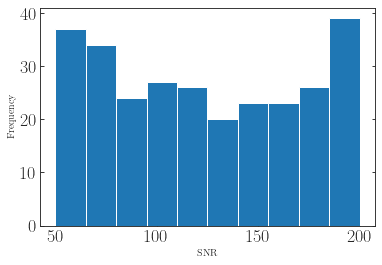

In [13]:
df_picks['MEDIAN_SNR' ].plot(kind='hist')
plt.xlabel('SNR')

In [14]:
import splat

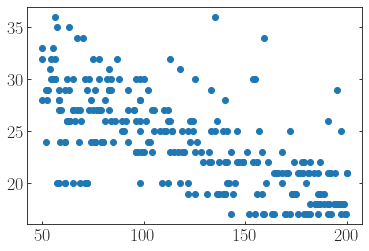

In [15]:
plt.scatter(df_picks.MEDIAN_SNR, df_picks.SPEX_TYPE.apply(splat.typeToNum))

In [16]:

def create_splat_source(filename):
    try:
        #create a wisps spectrum
        #retrieve splat spectrum

        splat_s=splat.getSpectrum(filename=filename)[0]
        spt=splat.typeToNum(splat_s.spex_type)

        #create a source object
        s=wisps.Spectrum( 
                       wave=splat_s.wave.value, 
                       flux=splat_s.flux.value,
                      noise=splat_s.noise.value)

        s.normalize()
        return s
    except OSError:
        return 

In [17]:
import wisps

In [18]:
df_picks['spt']=df_picks.SPEX_TYPE.apply(wisps.make_spt_number)

In [19]:
df_picks=df_picks.sort_values(by='spt')

In [20]:
#df_picks

In [21]:
%%capture
spectra=df_picks.DATA_FILE.apply(create_splat_source)

In [22]:
splat.initializeStandards()

In [23]:
splat.STDS_DWARF_SPEX['L0.0']

SPEX-PRISM spectrum of 2MASP J0345432+254023 (L0.0)

In [24]:
spectra[0].spt

'Y1.0'

In [25]:
def plot_sp_sp(s, ax):
    std=splat.STDS_DWARF_SPEX[s.spt]
    std.normalize(waverange=[1.1, 1.7])
    mask2=np.logical_and(std.wave.value>0.8, std.wave.value<1.7)
    ax.plot(std.wave.value[mask2], std.flux.value[mask2], linestyle='--')
    
    mask=np.logical_and(s.wave>0.8, s.wave<1.7)
    ax.plot(s.wave[mask], s.flux[mask])
    ax.set_title("{} {} ".format(str(idx),s.spt ))


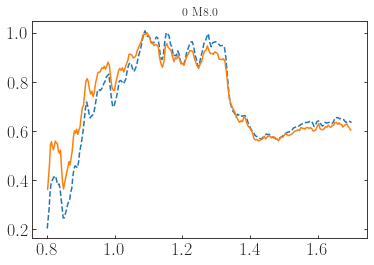

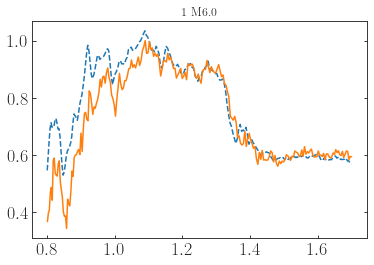

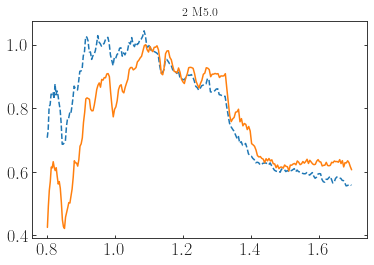

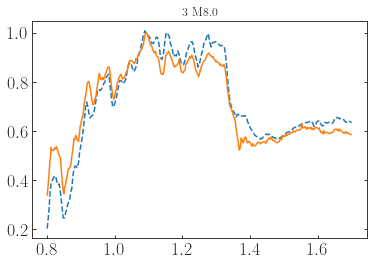

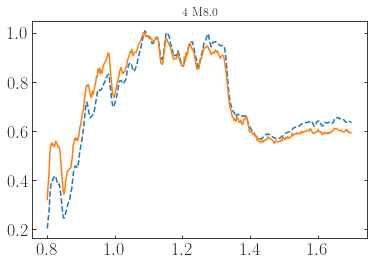

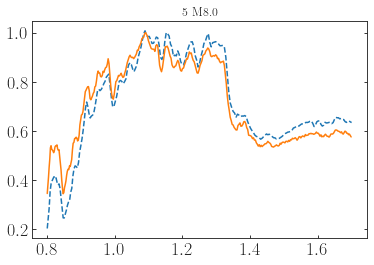

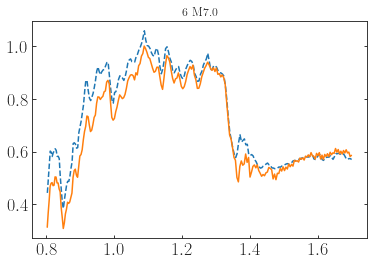

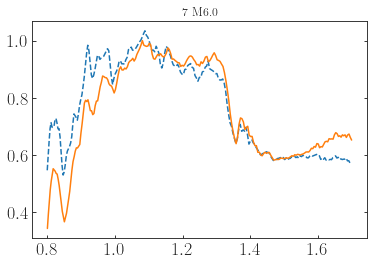

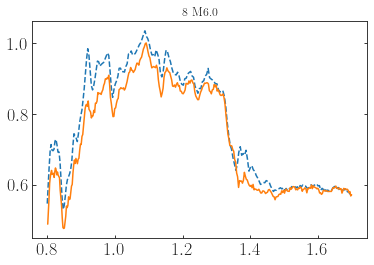

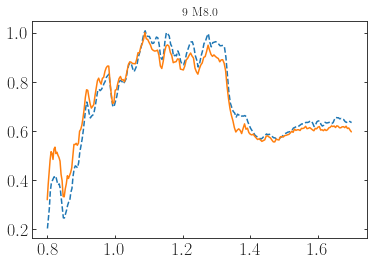

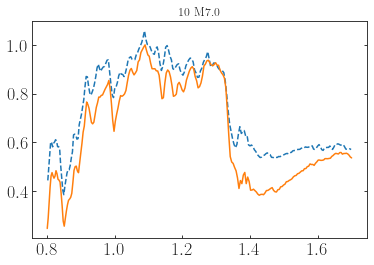

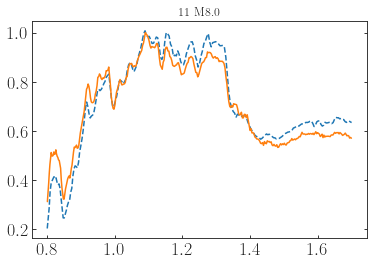

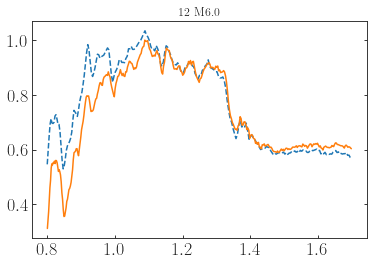

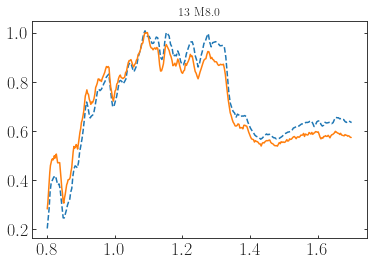

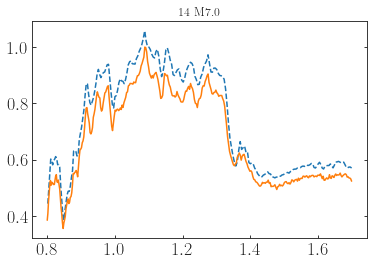

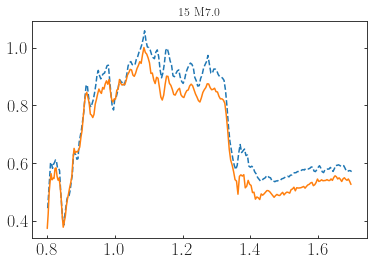

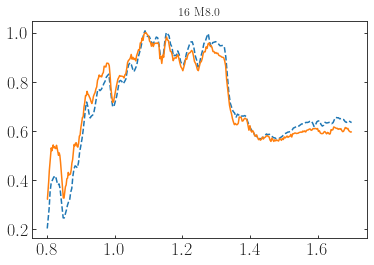

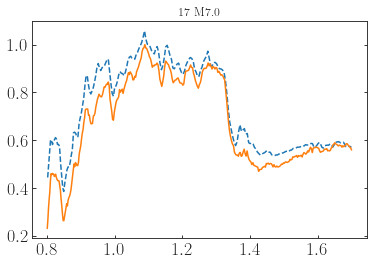

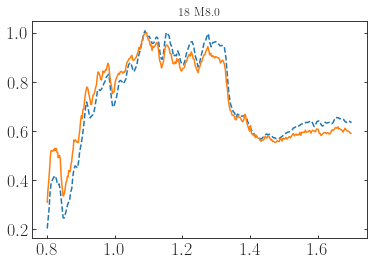

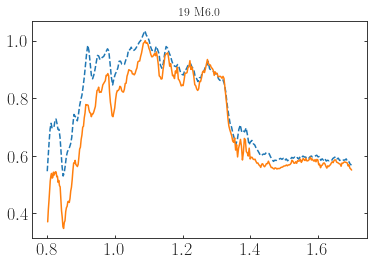

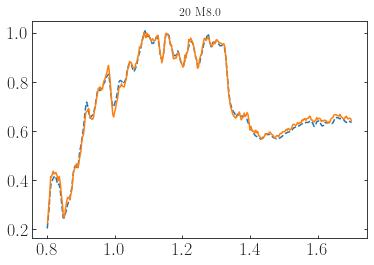

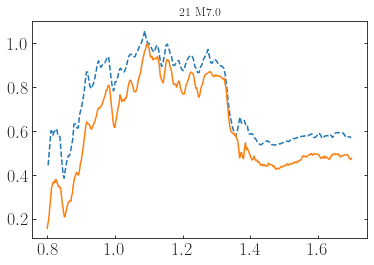

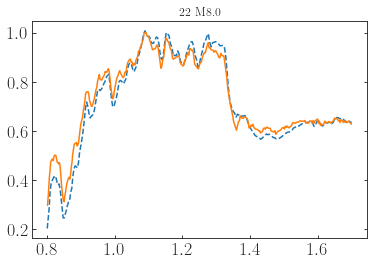

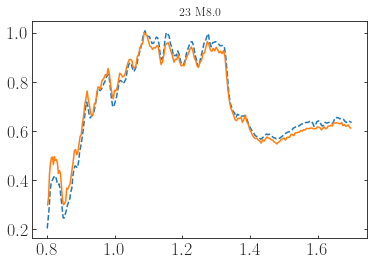

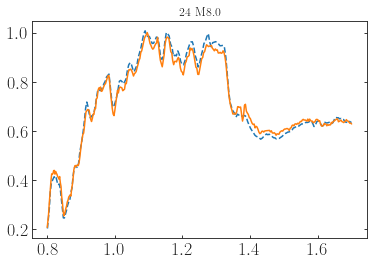

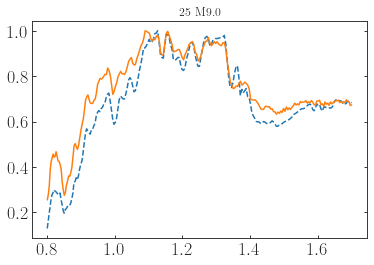

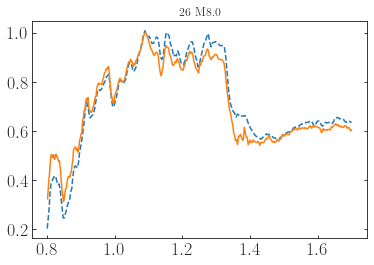

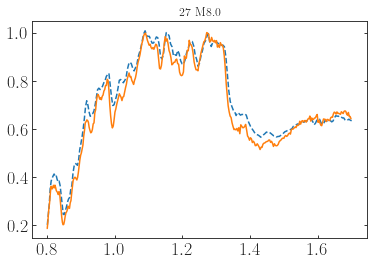

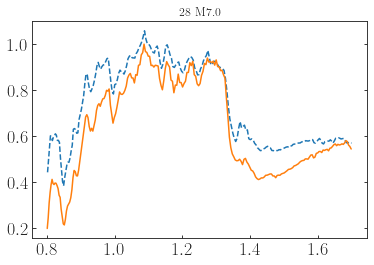

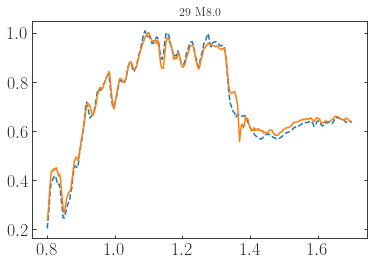

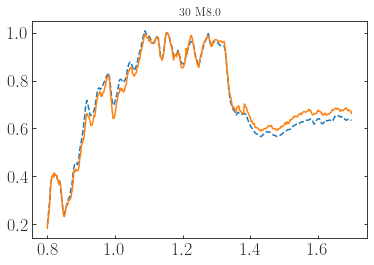

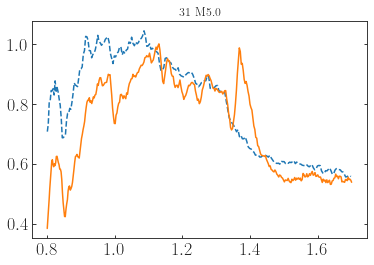

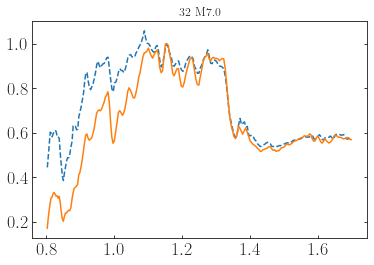

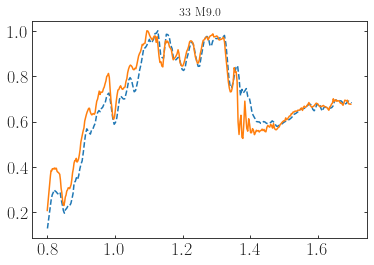

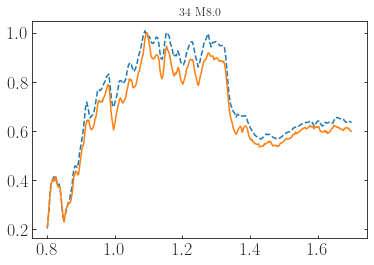

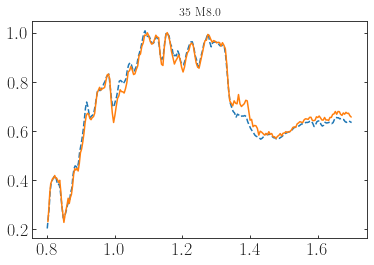

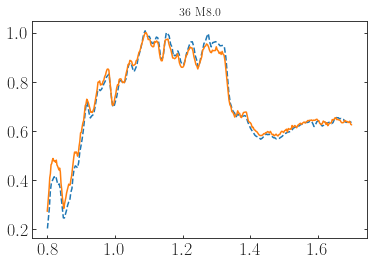

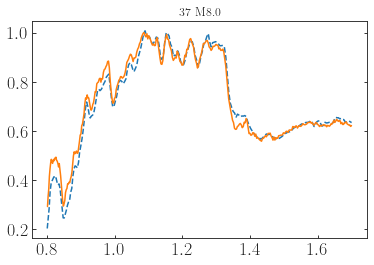

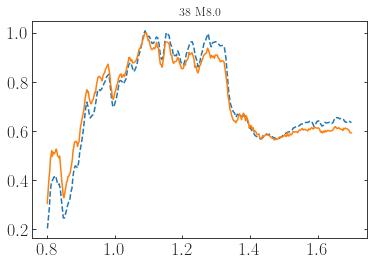

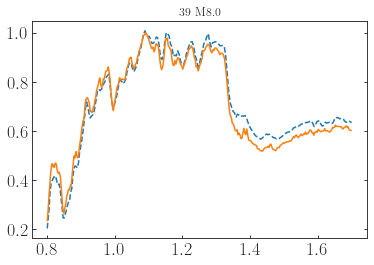

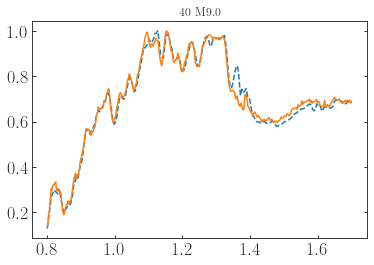

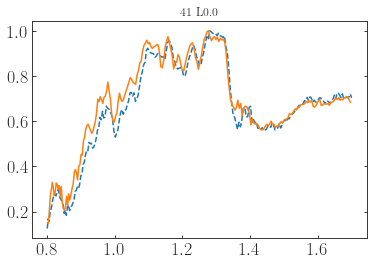

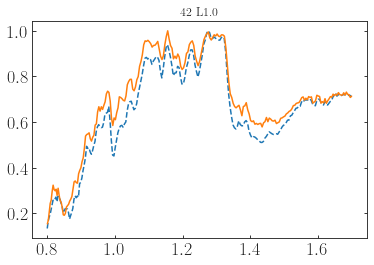

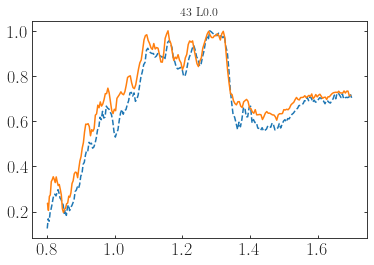

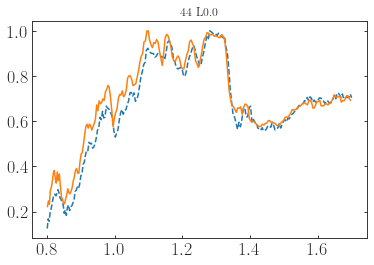

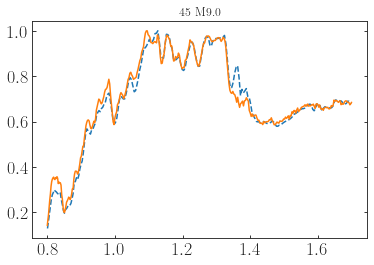

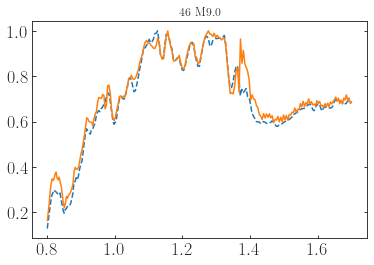

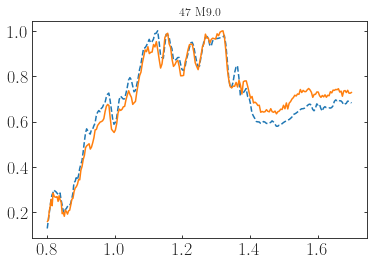

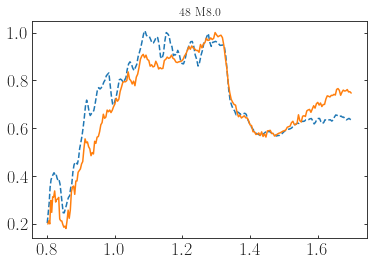

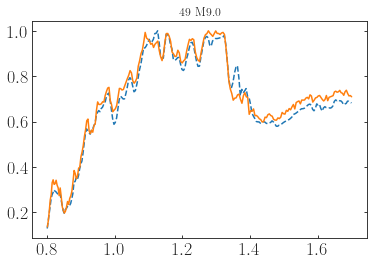

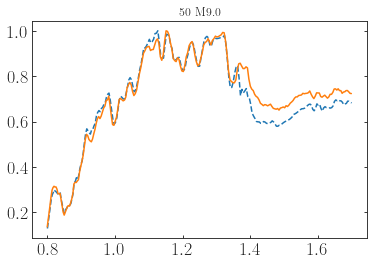

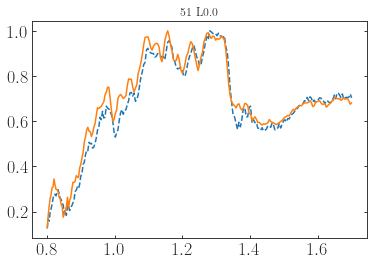

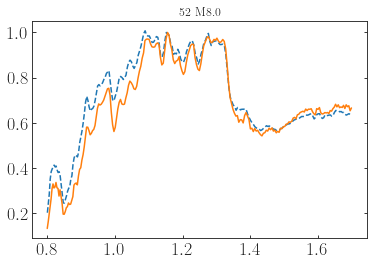

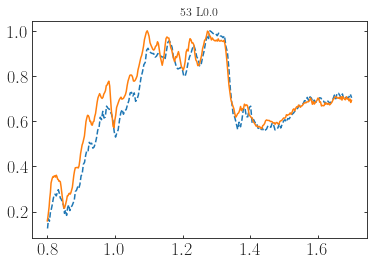

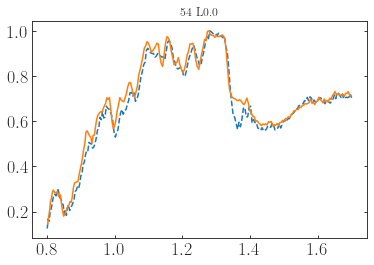

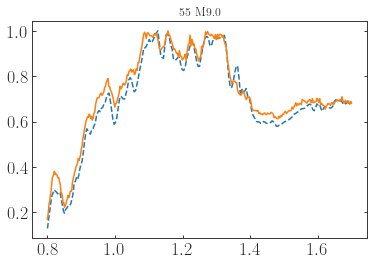

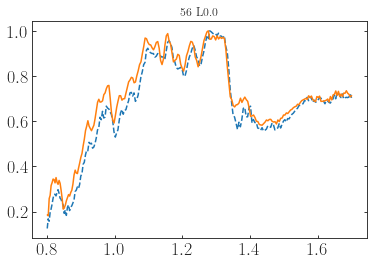

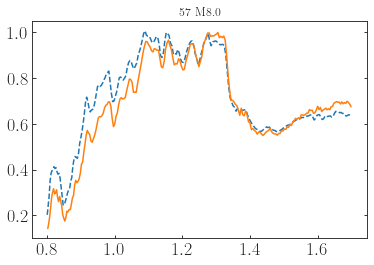

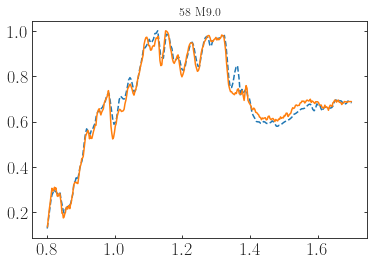

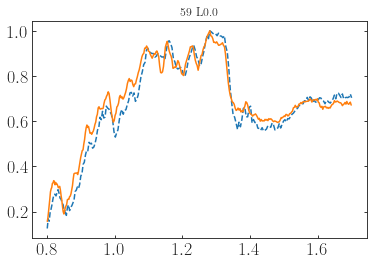

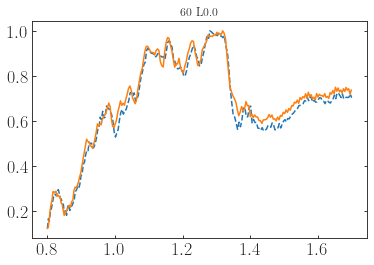

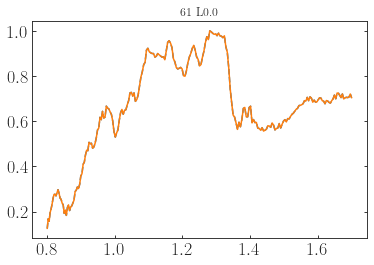

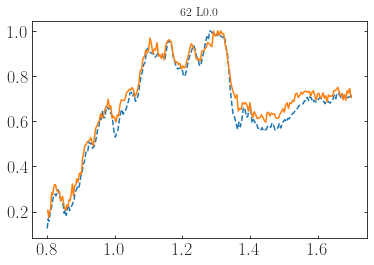

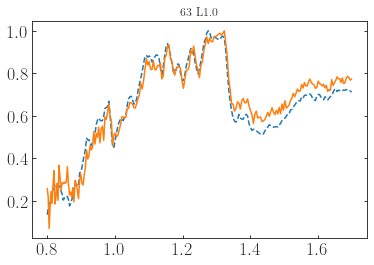

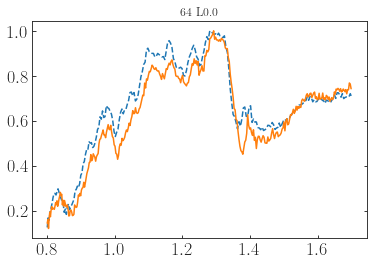

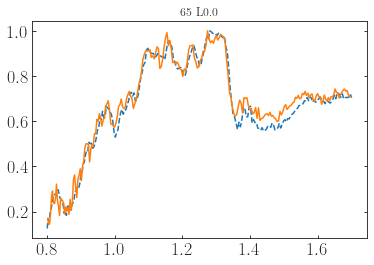

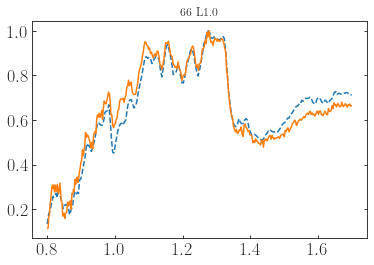

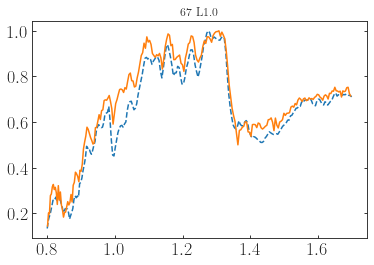

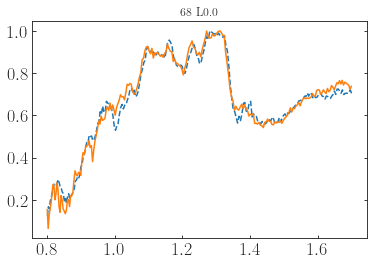

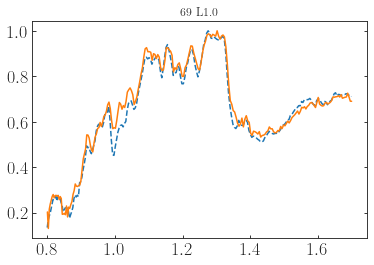

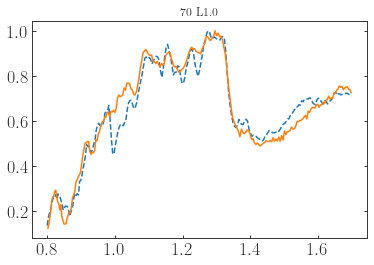

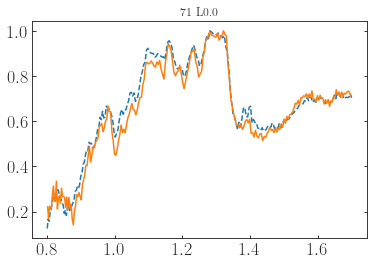

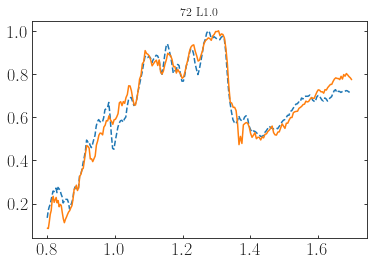

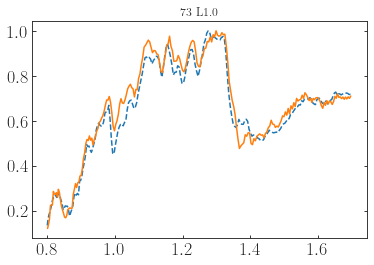

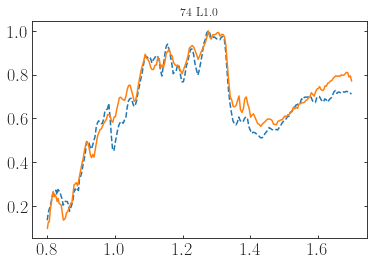

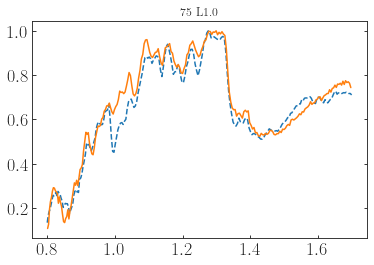

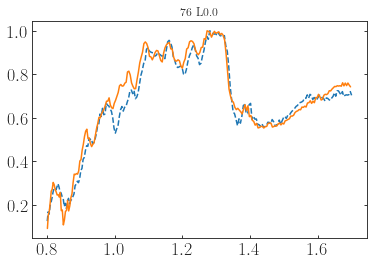

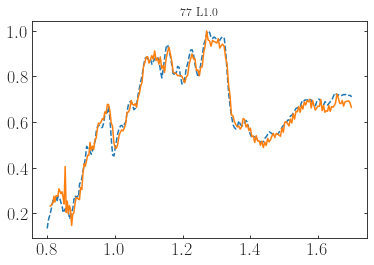

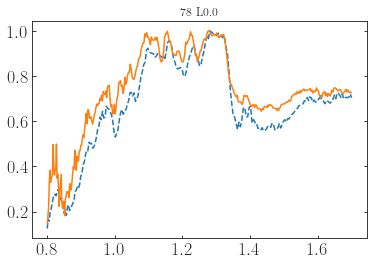

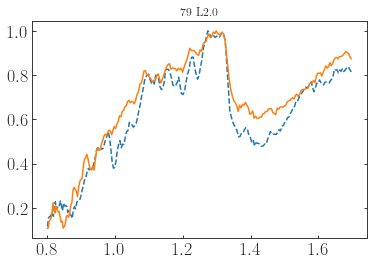

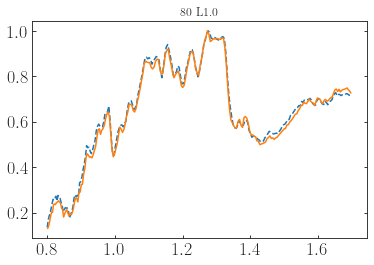

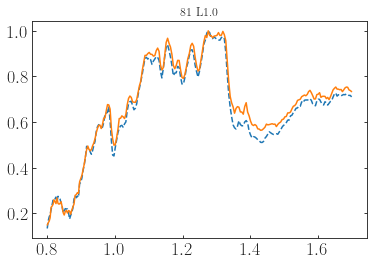

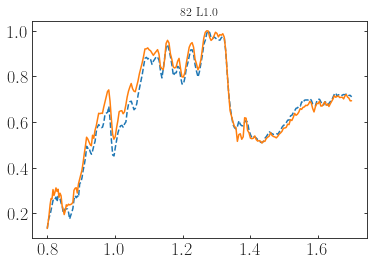

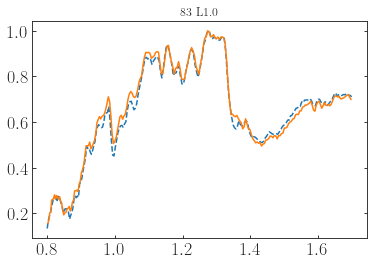

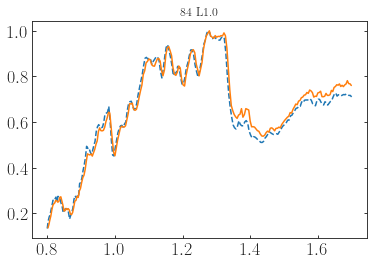

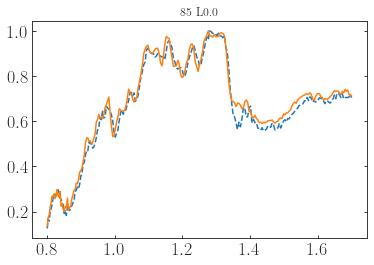

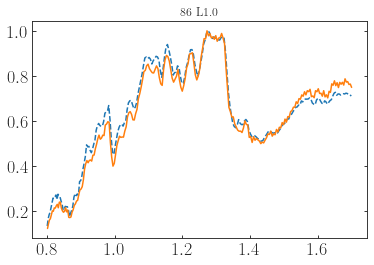

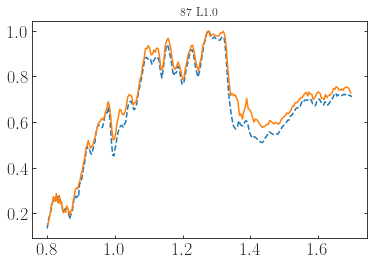

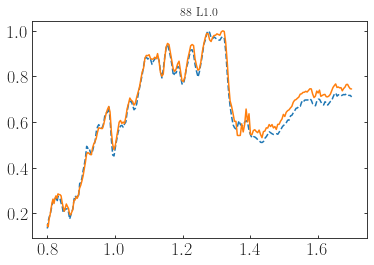

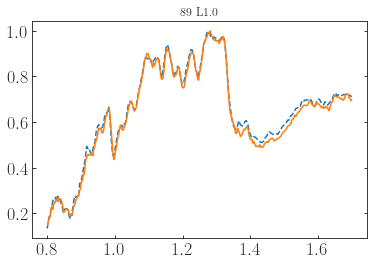

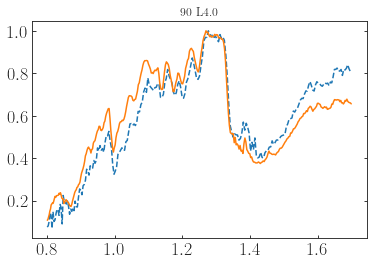

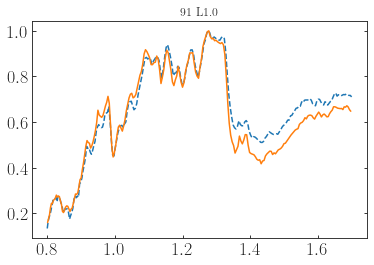

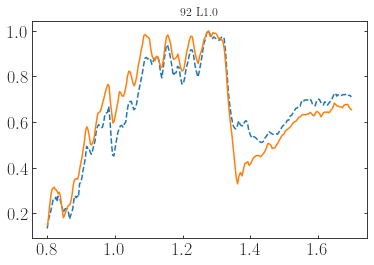

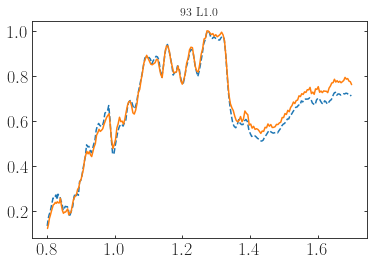

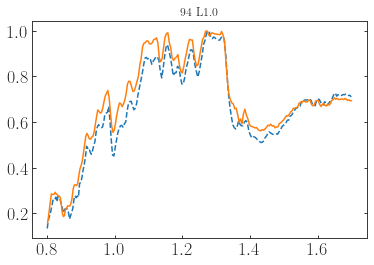

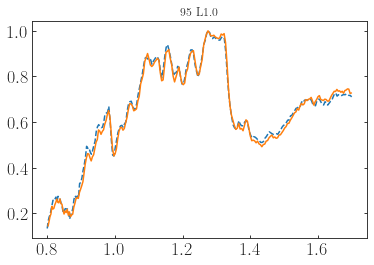

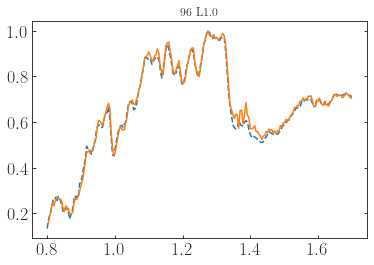

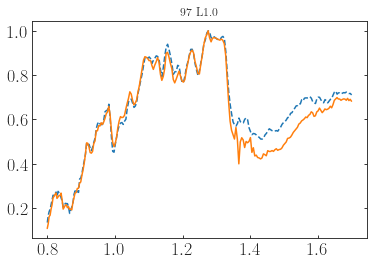

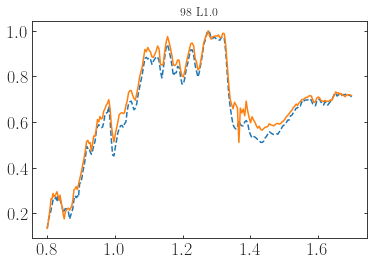

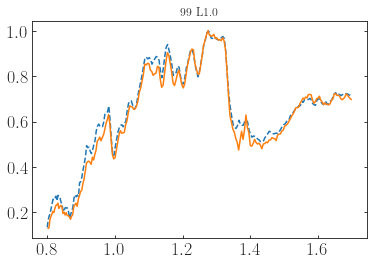

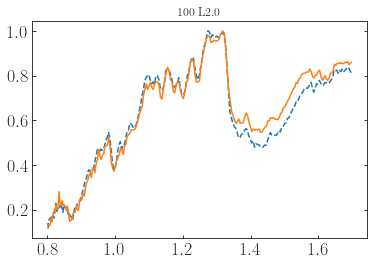

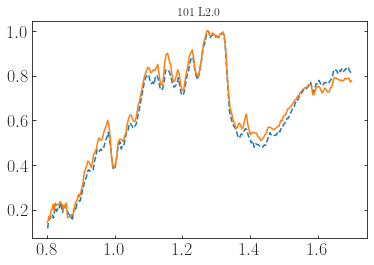

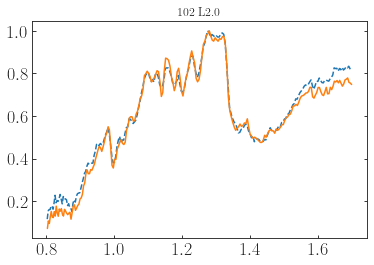

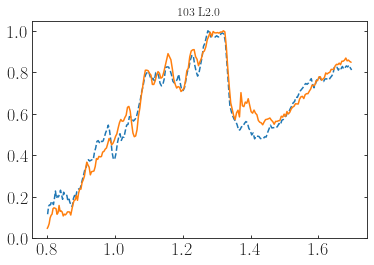

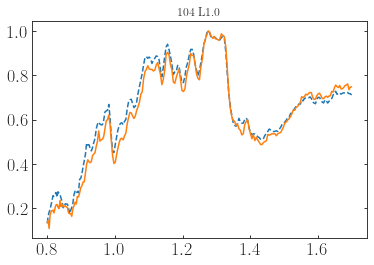

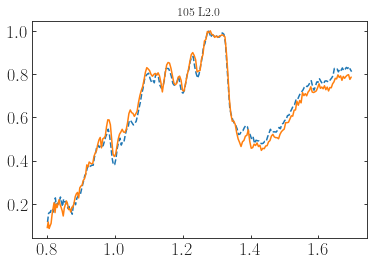

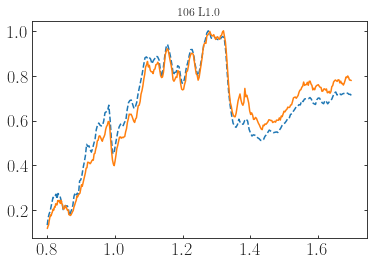

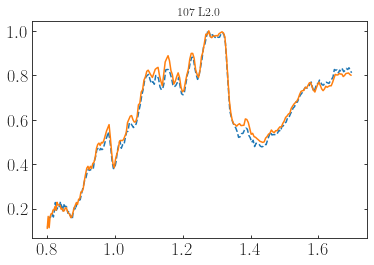

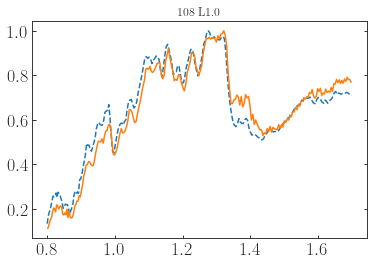

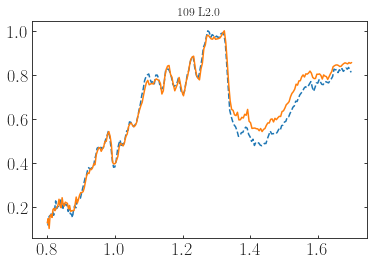

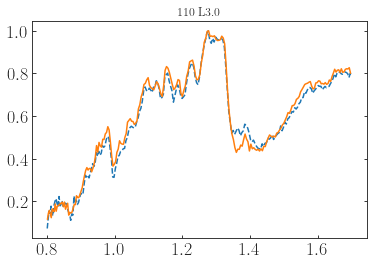

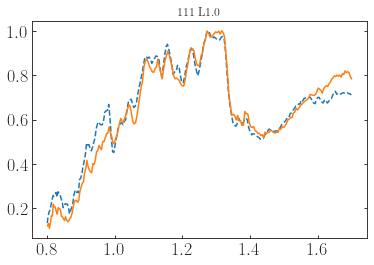

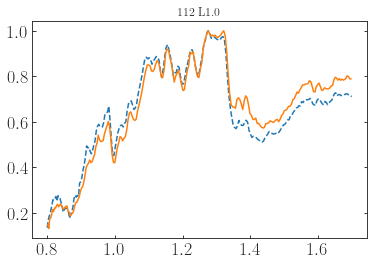

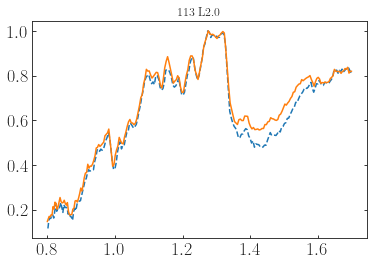

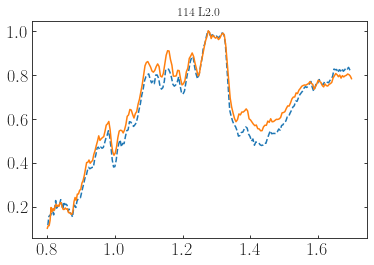

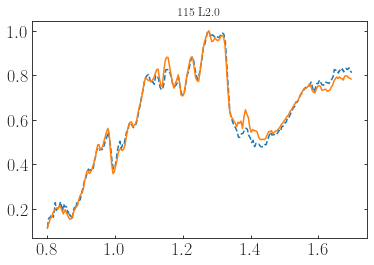

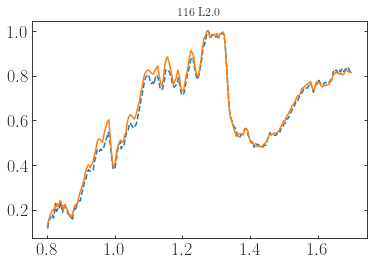

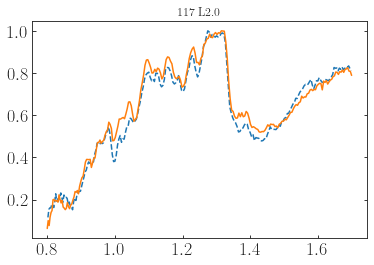

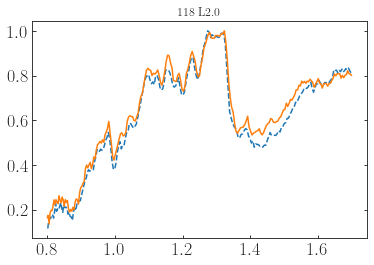

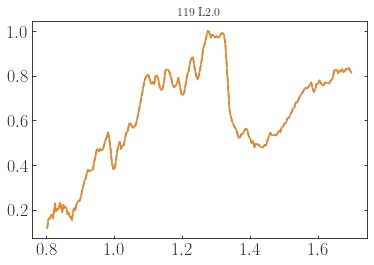

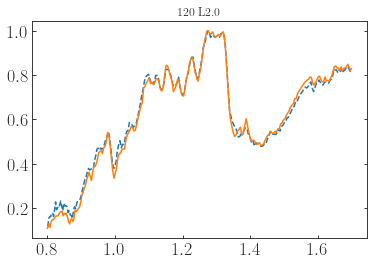

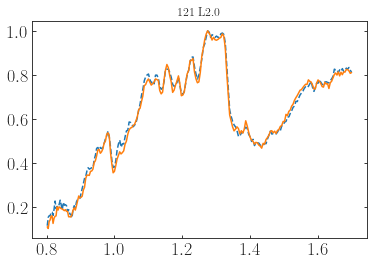

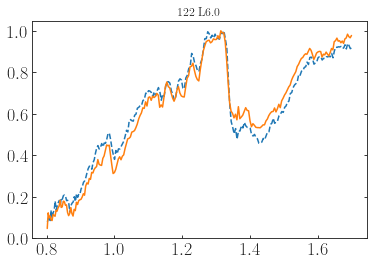

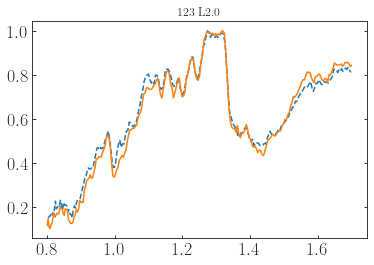

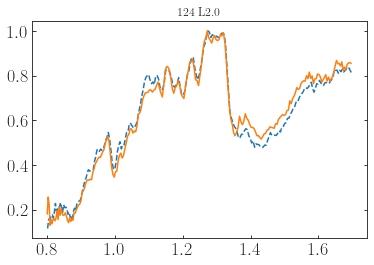

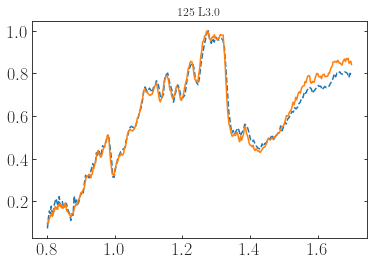

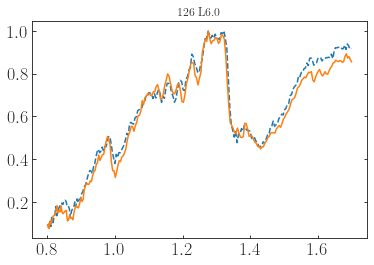

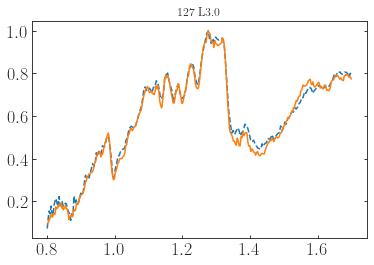

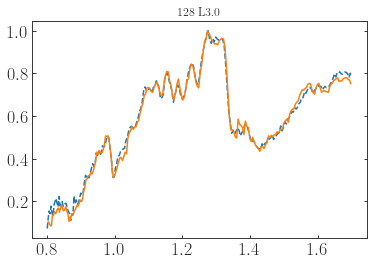

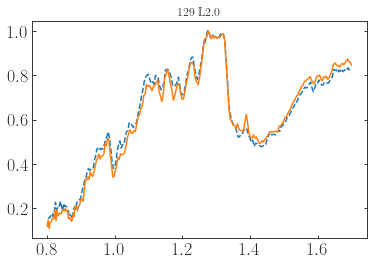

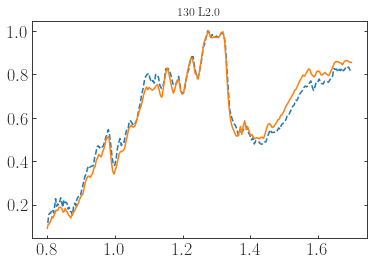

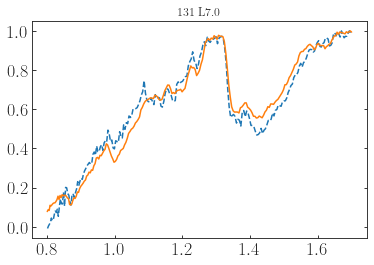

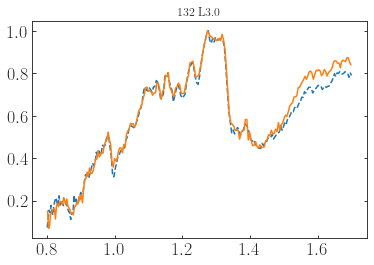

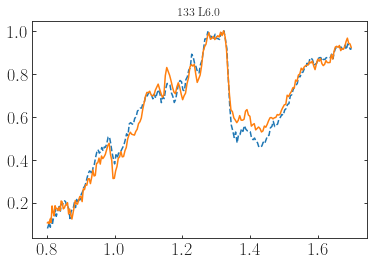

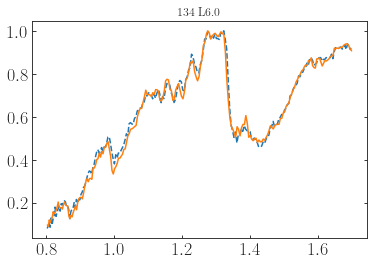

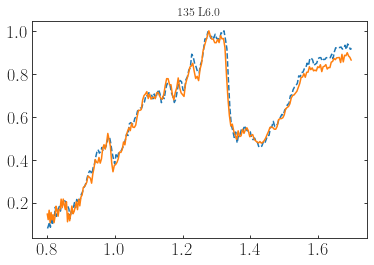

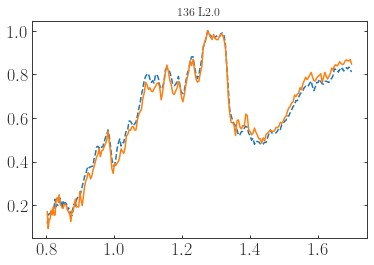

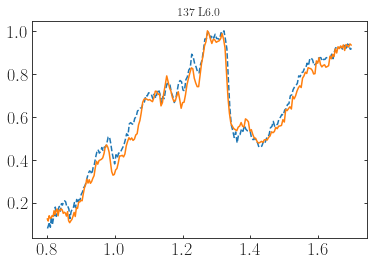

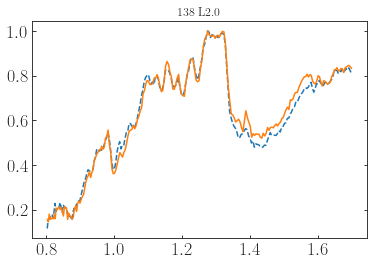

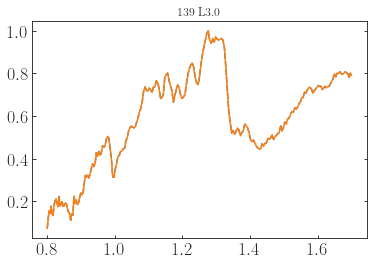

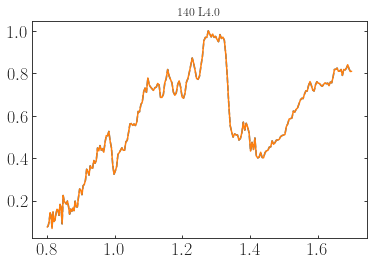

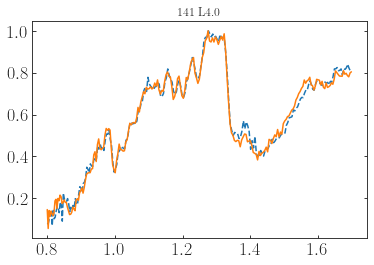

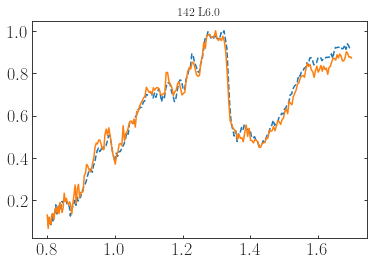

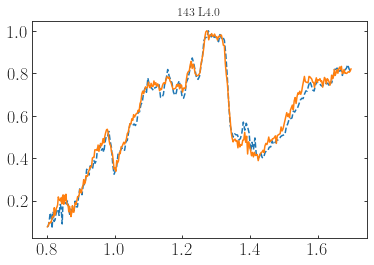

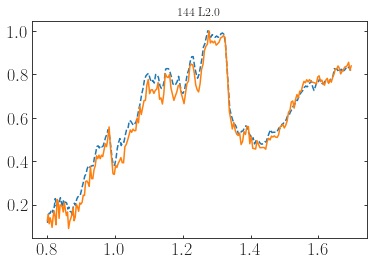

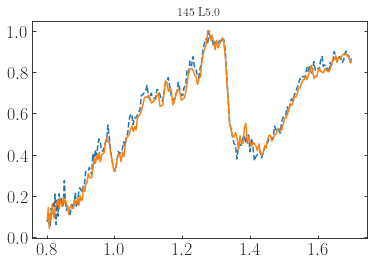

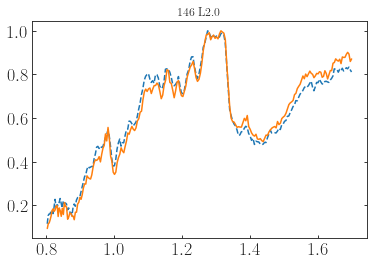

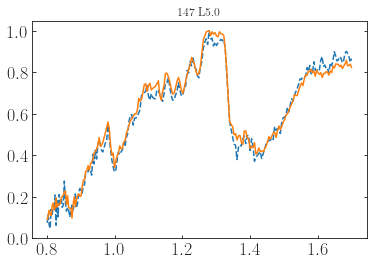

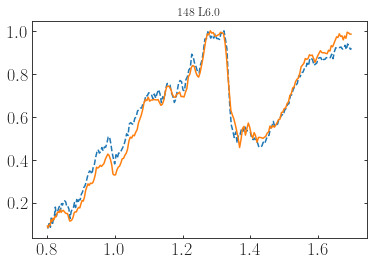

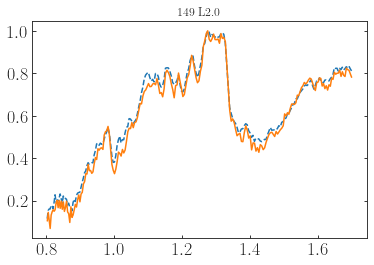

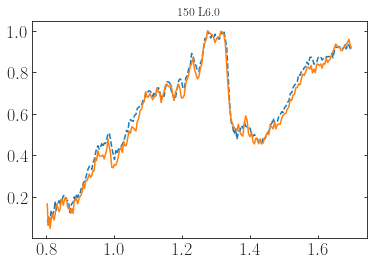

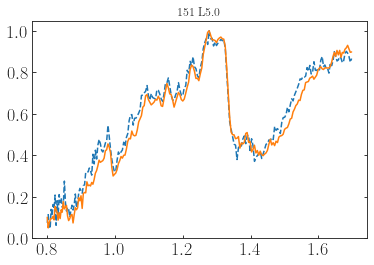

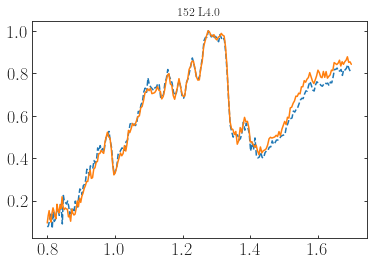

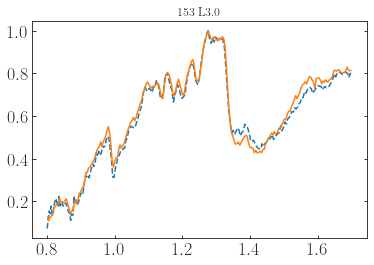

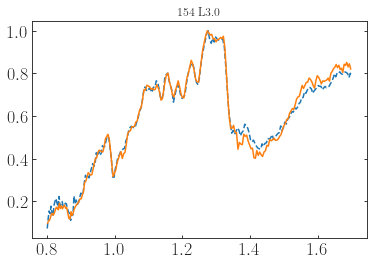

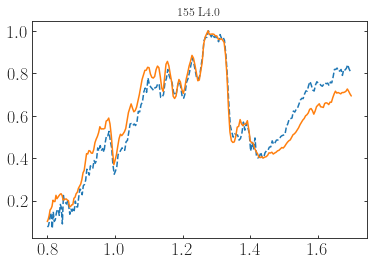

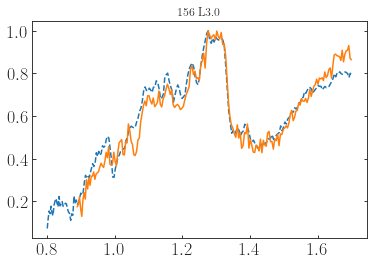

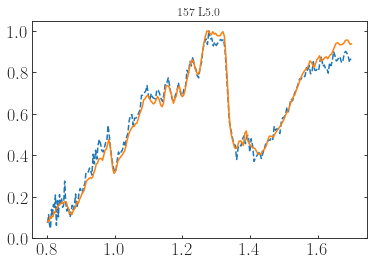

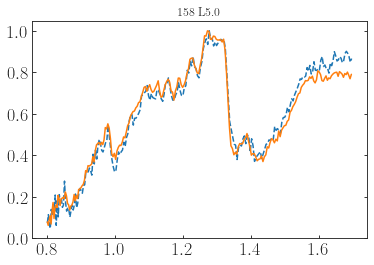

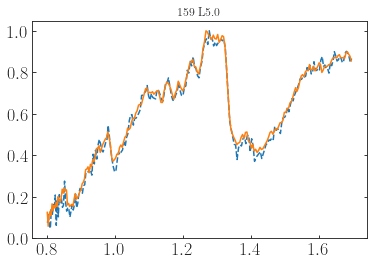

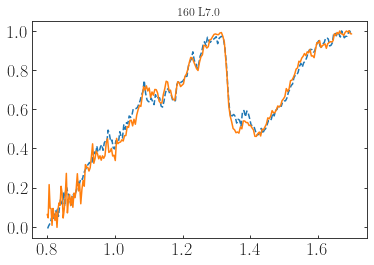

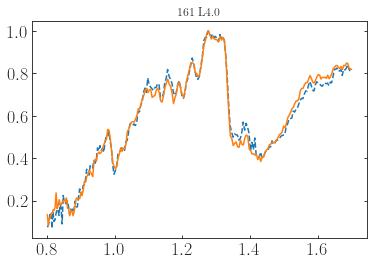

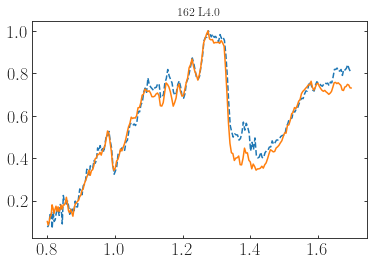

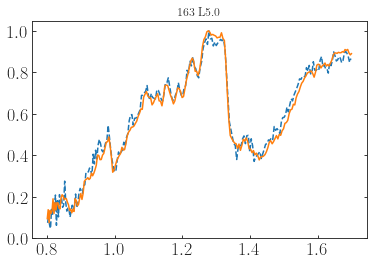

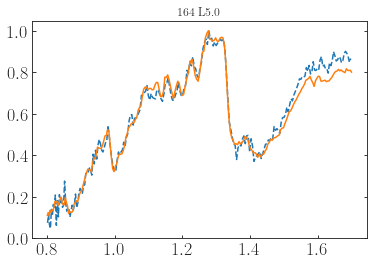

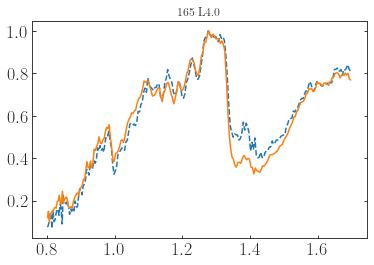

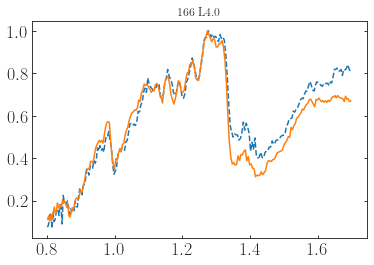

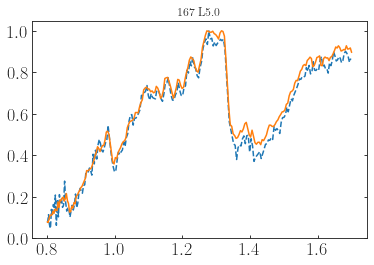

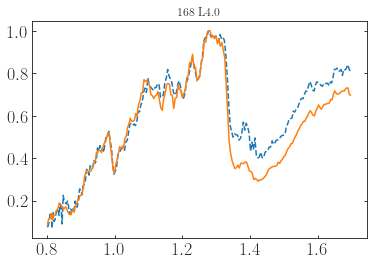

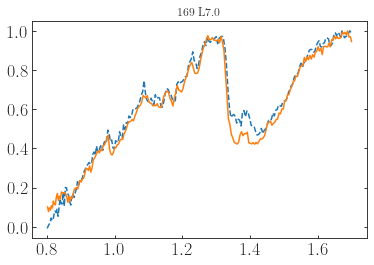

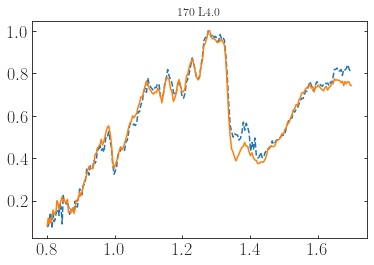

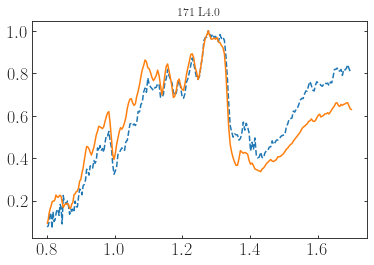

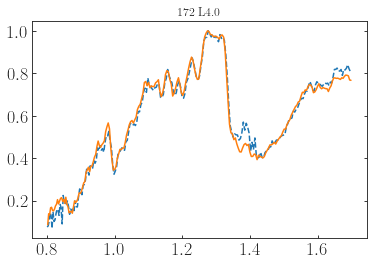

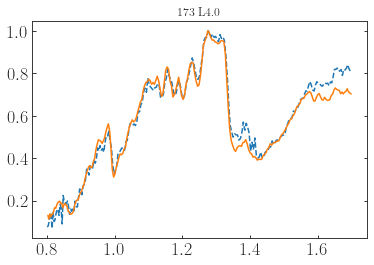

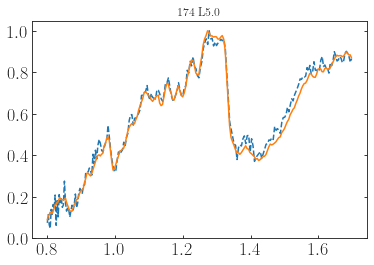

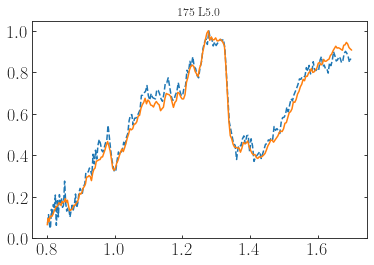

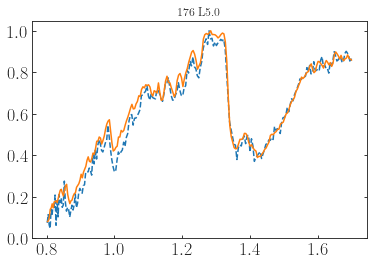

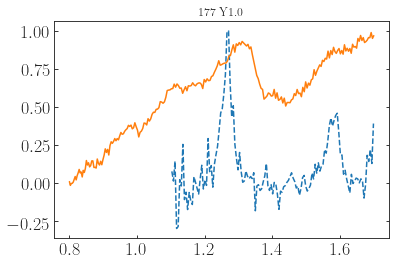

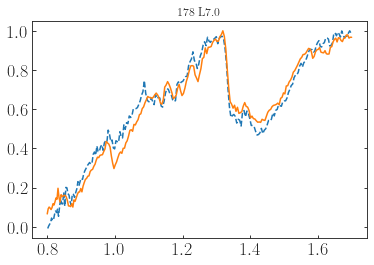

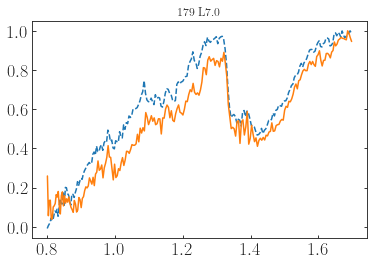

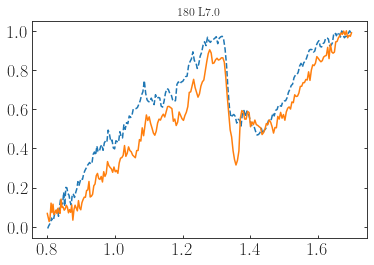

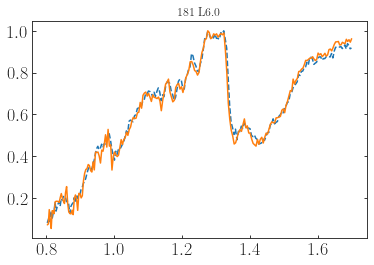

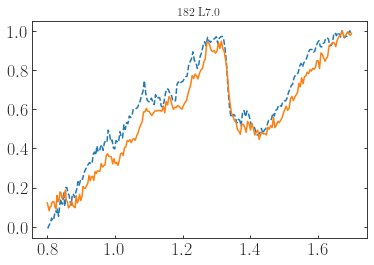

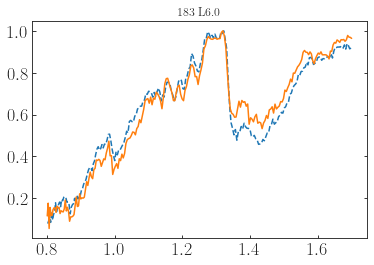

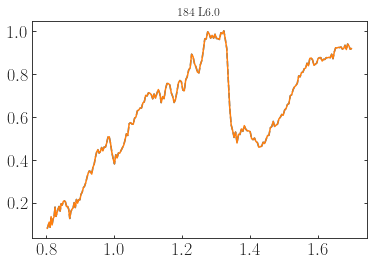

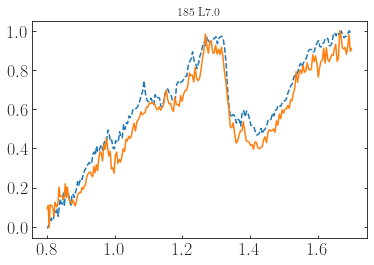

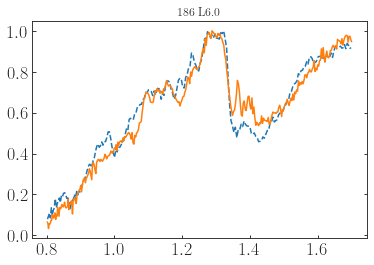

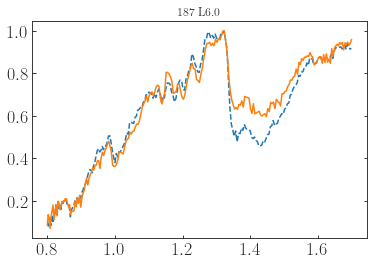

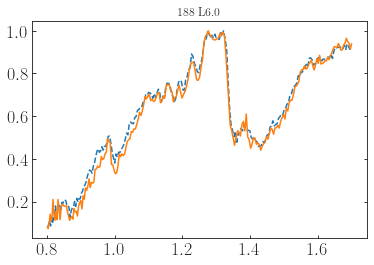

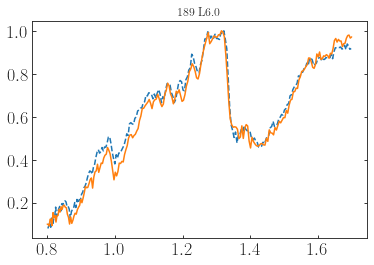

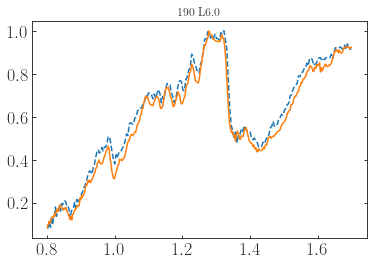

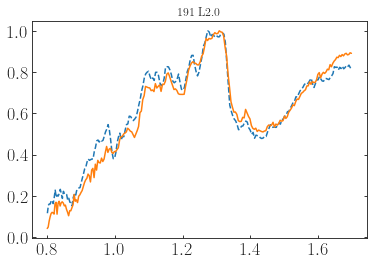

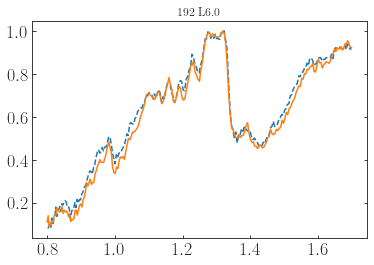

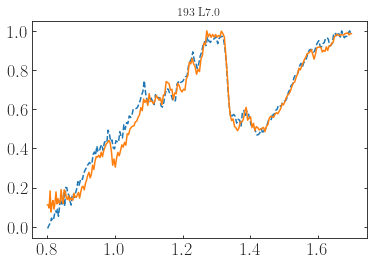

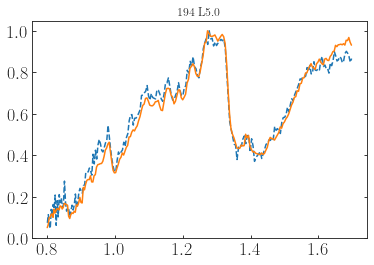

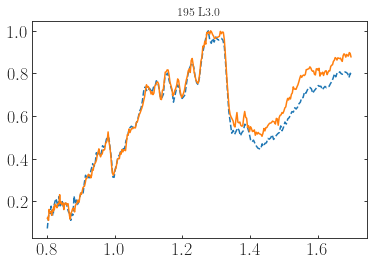

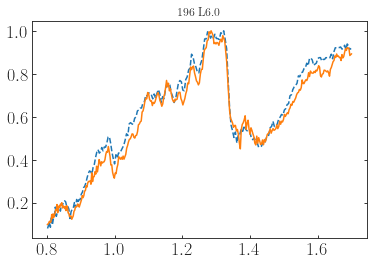

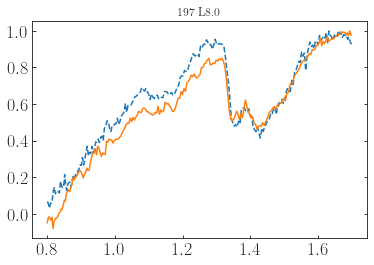

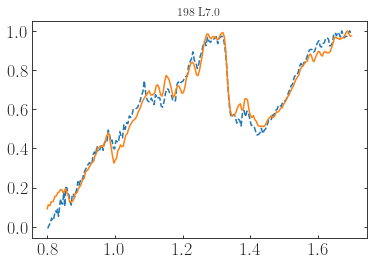

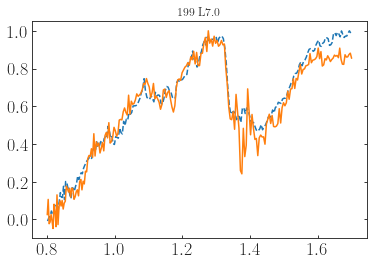

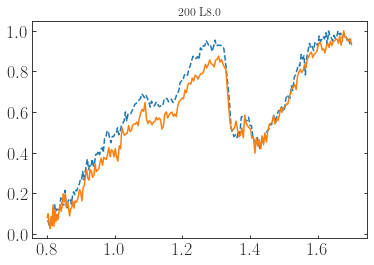

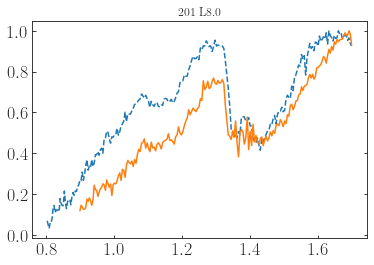

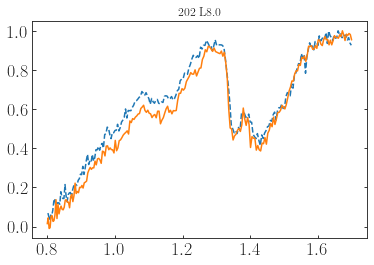

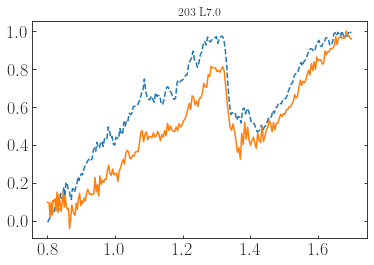

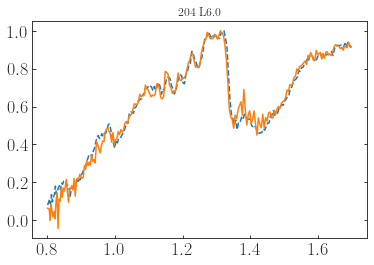

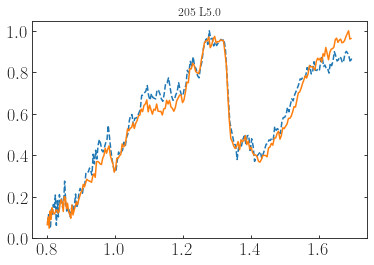

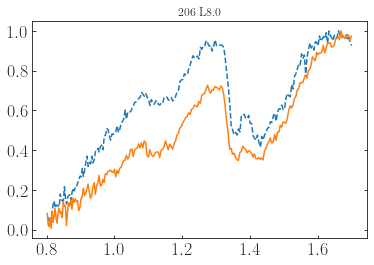

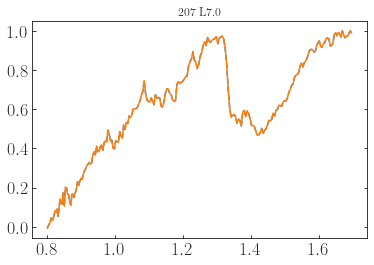

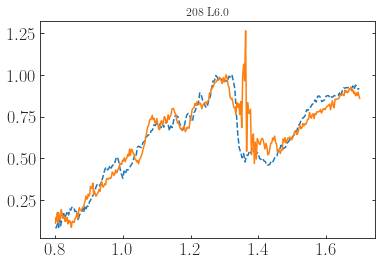

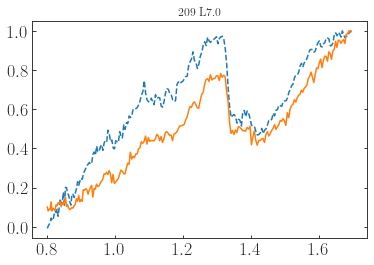

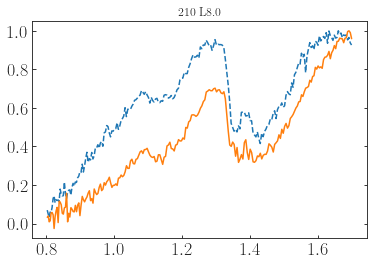

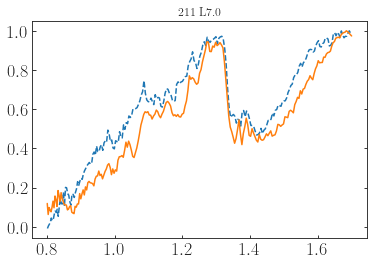

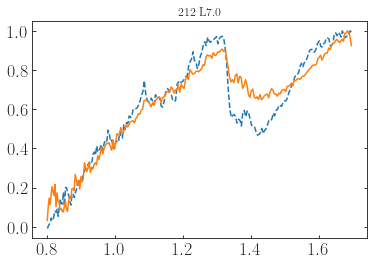

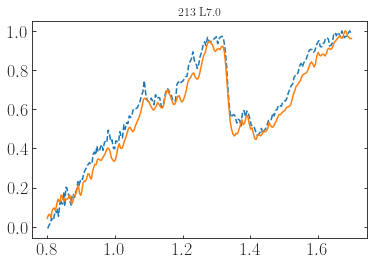

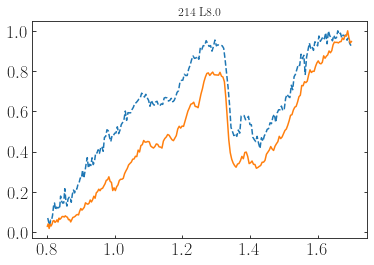

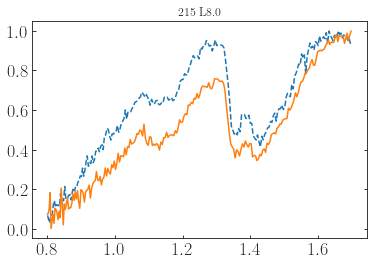

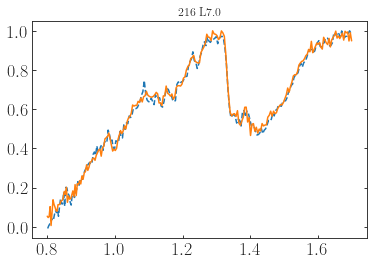

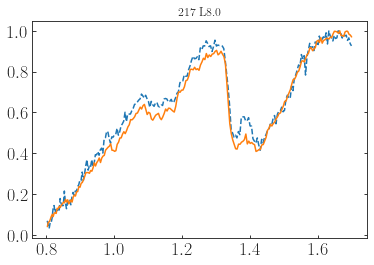

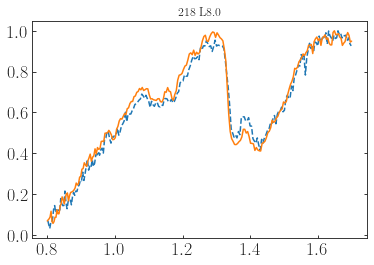

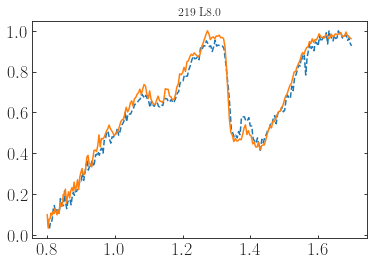

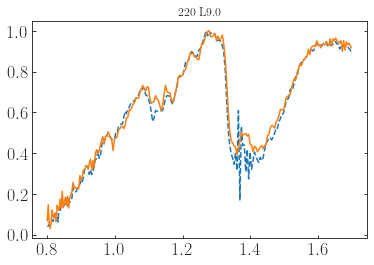

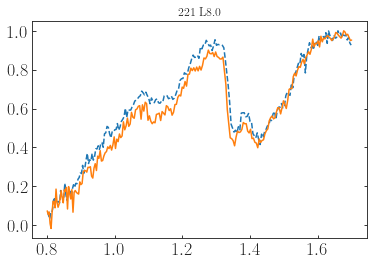

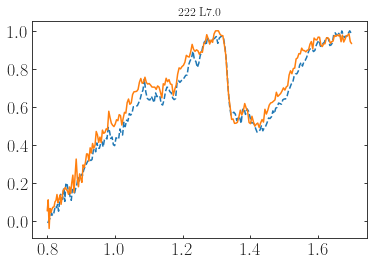

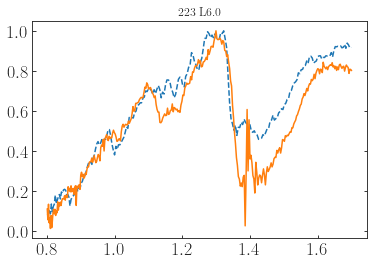

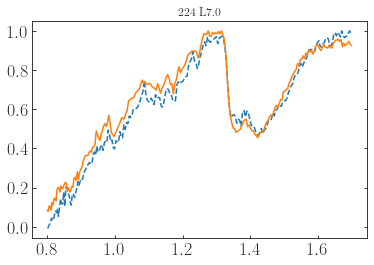

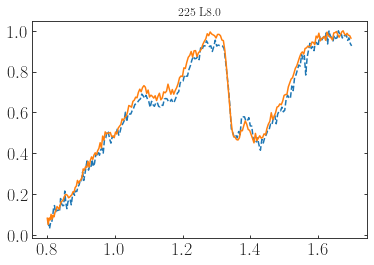

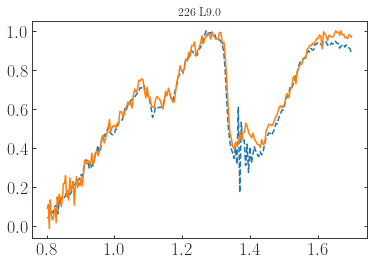

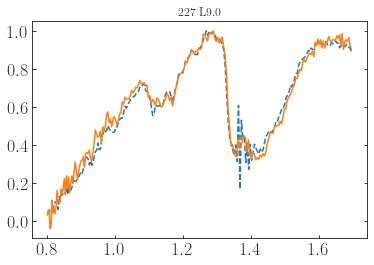

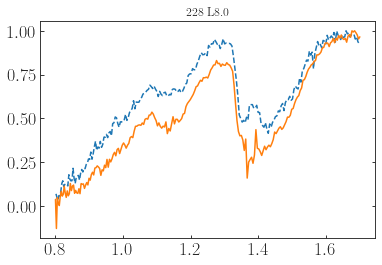

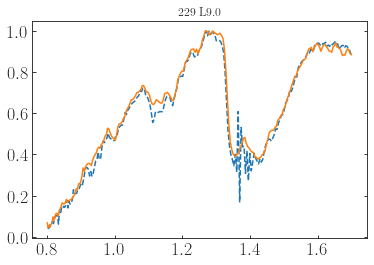

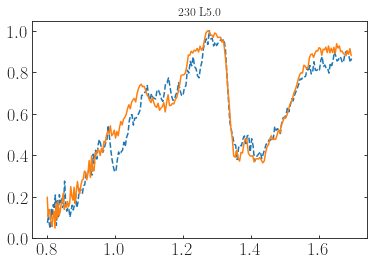

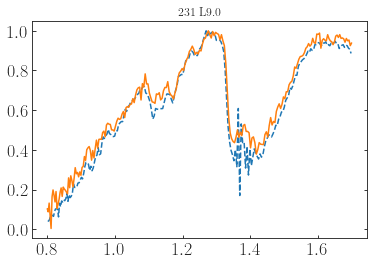

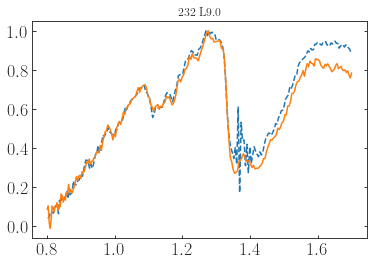

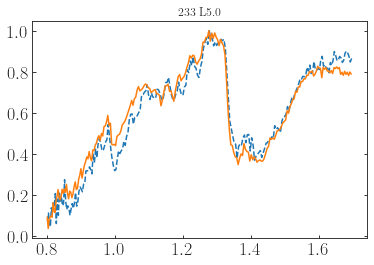

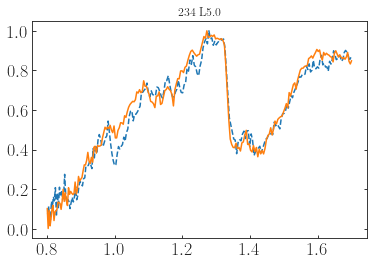

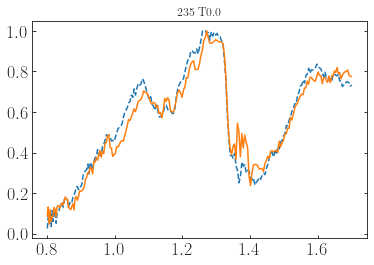

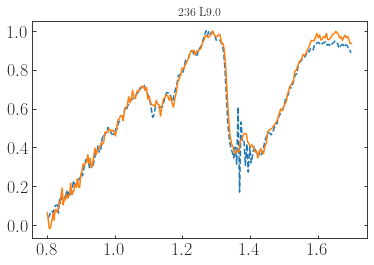

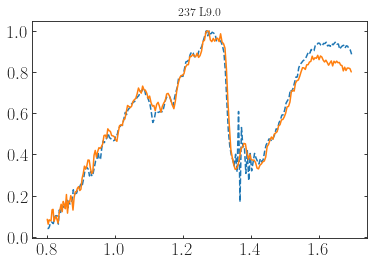

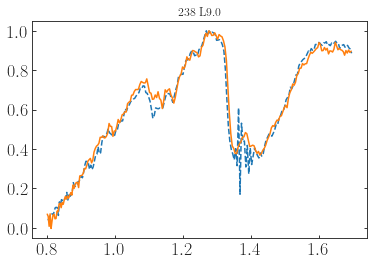

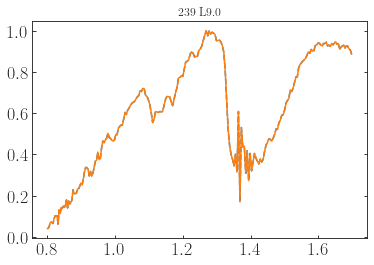

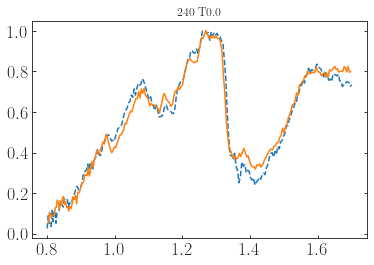

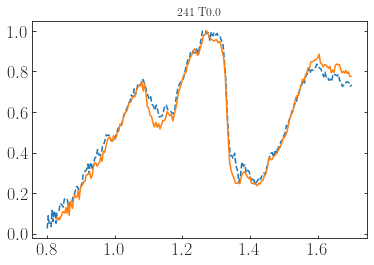

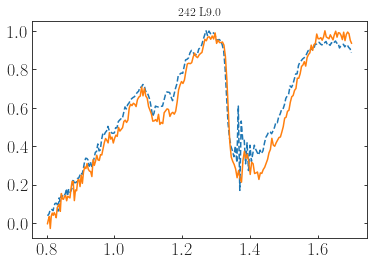

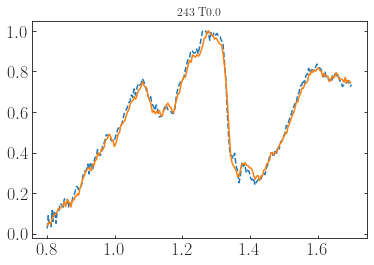

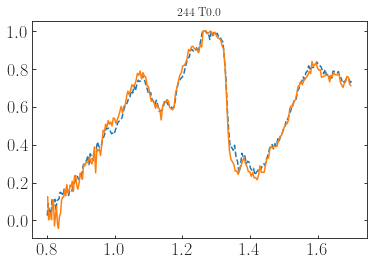

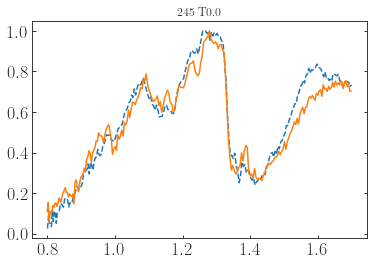

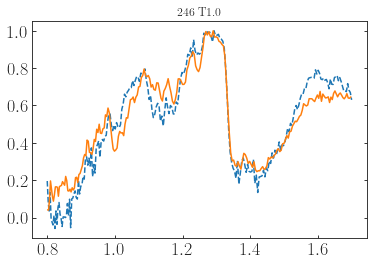

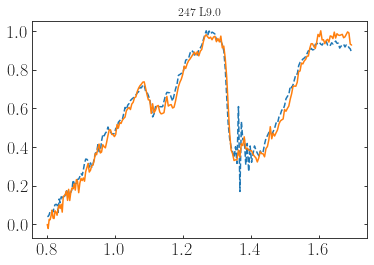

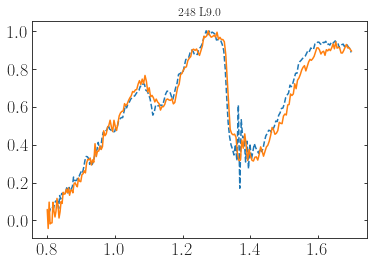

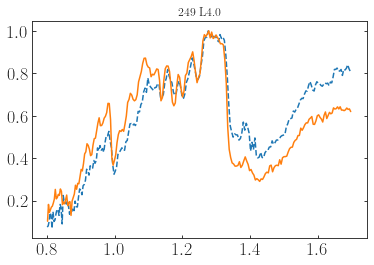

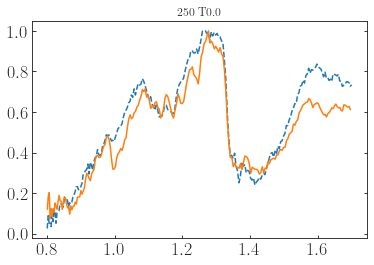

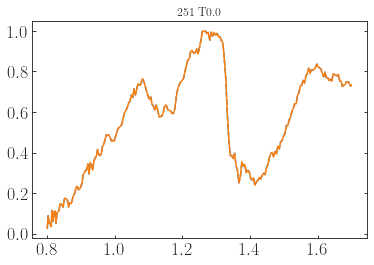

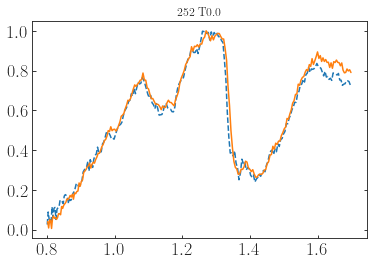

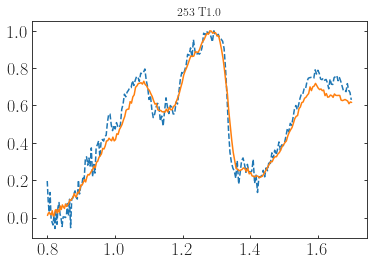

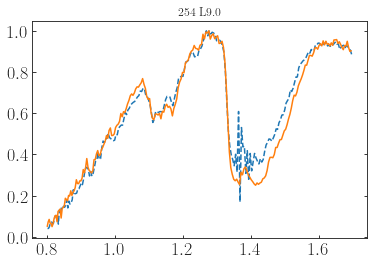

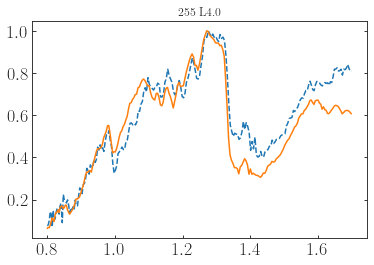

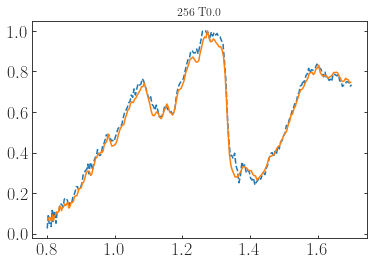

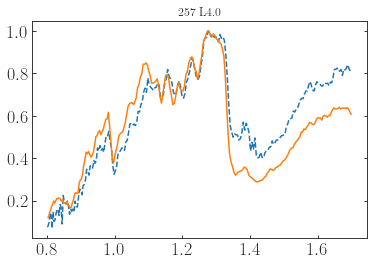

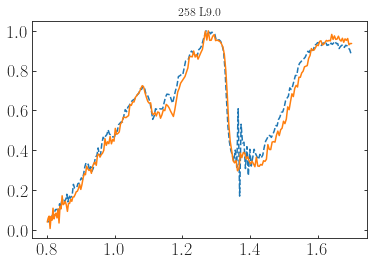

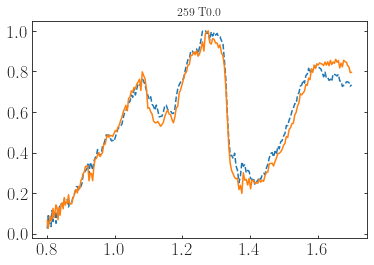

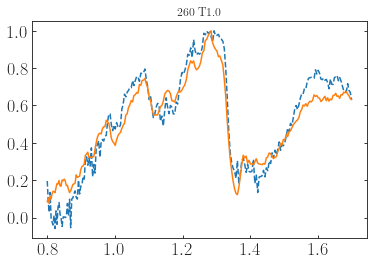

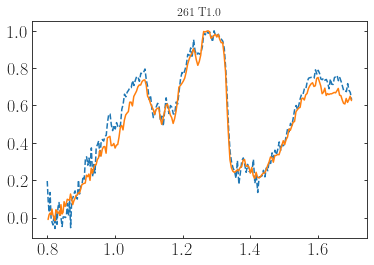

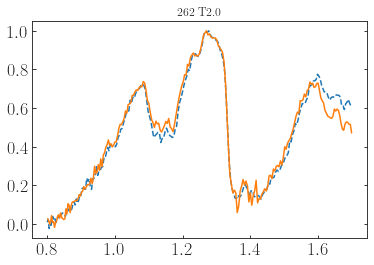

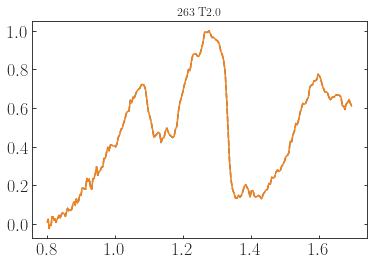

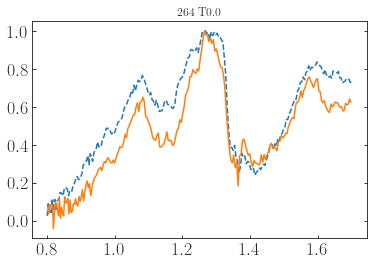

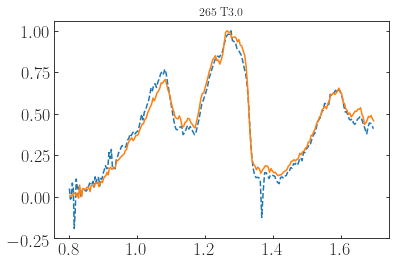

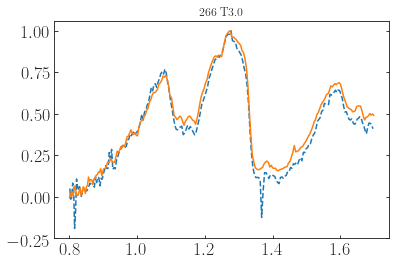

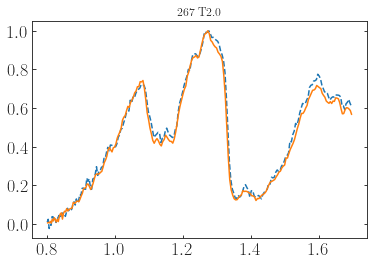

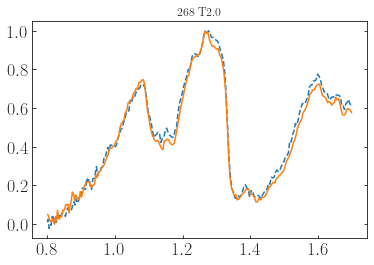

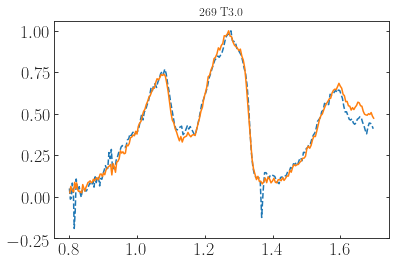

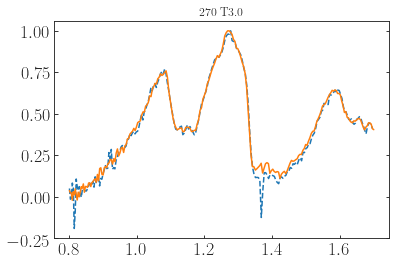

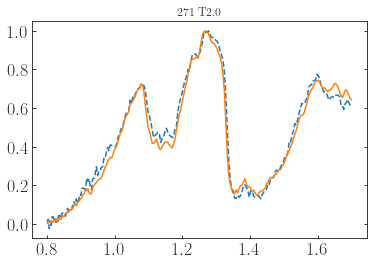

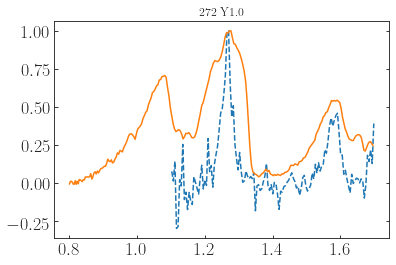

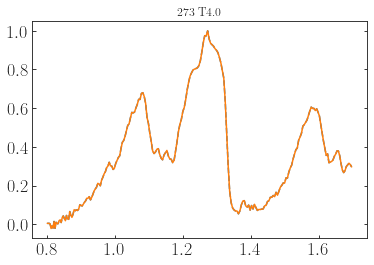

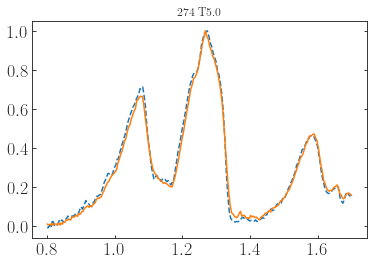

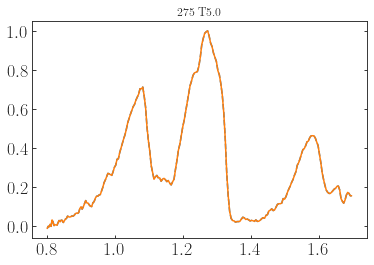

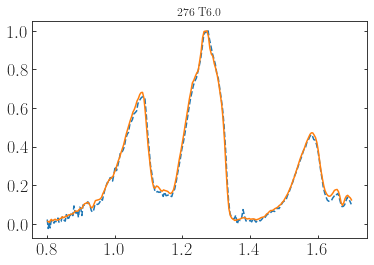

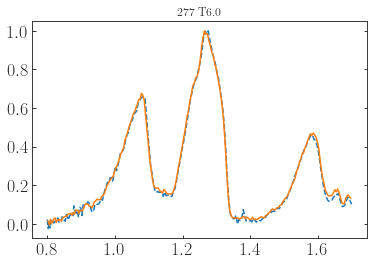

In [26]:
for idx, s in enumerate(spectra.dropna().values):
    s.normalize()
    fig, ax=plt.subplots()
    plot_sp_sp(s, ax)
    
        
            
    
   

In [27]:
def make_wisps(splat_s):
    s=wisps.Spectrum(wave=splat_s.wave.value, 
                       flux=splat_s.flux.value,
                      noise=splat_s.noise.value)
    return s

In [28]:
ydwarfs_data=pd.read_pickle('/users/caganze/y_standards.pkl')

In [29]:
ydwarfs_data.iloc[1].spec

WFC3-G141 spectrum of WISE0350-5658

In [30]:
t9s=splat.getSpectrum(spt='T9.0')
t8s=splat.getSpectrum(spt='T8.0')
t7s=splat.getSpectrum(spt='T7.0')
y0=ydwarfs_data.iloc[0].spec
y1=ydwarfs_data.iloc[1].spec


Retrieving 2 files


Retrieving 14 files


Retrieving 19 files



In [31]:
extras=[make_wisps(x) for x in np.concatenate([t9s, t8s, t7s, [y0], [y1]])]

In [32]:
remove=[204]

In [33]:
retain=np.append(np.delete(spectra.dropna().values, remove), extras)

In [34]:
import pickle
with open(wisps.OUTPUT_FILES+'/l_t_dwarfs_spex.pkl', 'wb') as file:
    pickle.dump(retain,file)

In [35]:
import pandas as pd
import wisps 

In [36]:
res=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl')

In [37]:
res_df=wisps.Annotator.reformat_table(res)

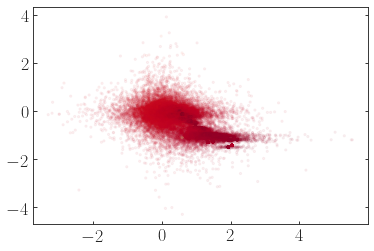

In [39]:
plt.scatter(res_df['H-cont/H_2O-2'].apply(np.log10), 
            res_df['CH_4/J-Cont'].apply(np.log10), s=5,alpha=0.05, c=res_df.snr1.apply(np.log10).values, cmap='YlOrRd')